### Use kernel conda_tensorflow2_p310

In [1]:
import boto3
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import feature_column
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder

In [2]:
# verify GPU 
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
print(tf.__version__)

2.11.0


In [4]:
%run ./read_file.ipynb

:: loading settings :: url = jar:file:/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ec2-user/.ivy2/cache
The jars for the packages stored in: /home/ec2-user/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-62a5035b-85bc-4a02-8c5b-28a42471ff17;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
downloading https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar ...
	[SUCCESSFUL ] graphframes#graphframes;0.8.2-spark3.2-s_2.12!graphframes.jar (74ms)
downloading https://repo1.maven.org/maven2/org/slf4j/slf4j-api/1.7.16/slf4j-api-1.7.16.jar ...
	[SUCCESSFUL ] org.slf4j#slf4j-api;1.7.16!slf4j-api.jar (29ms)
:: resolution report :: resolve 860ms :: artifacts dl 108ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	-------

23/03/30 06:05:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/30 06:05:42 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [5]:
# https://stackoverflow.com/questions/68036975/valueerror-shape-must-be-at-least-rank-3-but-is-rank-2-for-node-biasadd
# config for rank error in lstm
tf.config.threading.set_inter_op_parallelism_threads(16)
pd.set_option('display.max_columns', None)
tf.keras.backend.set_image_data_format("channels_last")

In [6]:
# Set Config
embedding_dim = 64
max_length = 6
sequence_length = 6
max_features = 10000
padding_type = 'post'
trunc_type = 'post'
training_portion = 0.8

hparams = {
    "batch_size": 128,
    "cnn_filter_sizes": [128, 128, 128],
    "cnn_kernel_sizes": [5, 5, 5],
    "cnn_pooling_sizes": [5, 5, 40],
    "constraint_learning_rate": 0.01,
    "embedding_dim": 100,
    "embedding_trainable": False,
    "learning_rate": 0.005,
    "max_num_words": 10000,
    "max_sequence_length": 250
}

In [7]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [8]:
ds = spark.read.parquet("s3a://sapient-bucket-trusted/prod/tensor_sample_data/test_holdout/*").cache()

In [9]:
tot = ds.count()

In [29]:
dat = spark.read.parquet("s3a://sapient-bucket-trusted/prod/graph/encoded/sample3/*").cache()

In [30]:
tot2 = dat.count()

In [31]:
dat.groupBy("malicious") \
    .count() \
    .withColumnRenamed('count', 'cnt_per_group') \
    .withColumn('perc_of_count_total', (col('cnt_per_group') / tot2) * 100 ) \
    .sort("perc_of_count_total").show()

+---------+-------------+-------------------+
|malicious|cnt_per_group|perc_of_count_total|
+---------+-------------+-------------------+
|        1|         2338| 0.5007142352328922|
|        0|       464595|  99.49928576476711|
+---------+-------------+-------------------+



In [10]:
df = spark.read.parquet("s3a://sapient-bucket-trusted/prod/tensor_sample_data/test_holdout/*").cache().toPandas()

In [11]:
df.count()

Trace             2598111
malicious         2598111
event_sequence    2598111
dtype: int64

In [12]:
len(df)

2598111

In [13]:
df.dtypes

Trace              int64
malicious          int32
event_sequence    object
dtype: object

In [14]:
ds.groupBy("malicious") \
    .count() \
    .withColumnRenamed('count', 'cnt_per_group') \
    .withColumn('perc_of_count_total', (col('cnt_per_group') / tot) * 100 ) \
    .sort("perc_of_count_total").show()

+---------+-------------+-------------------+
|malicious|cnt_per_group|perc_of_count_total|
+---------+-------------+-------------------+
|        1|         6517|0.25083608821947945|
|        0|      2591594|  99.74916391178053|
+---------+-------------+-------------------+



In [15]:
# Data conversion - https://towardsdatascience.com/multi-class-text-classification-with-lstm-using-tensorflow-2-0-d88627c10a35
tokenizer = tf.keras.preprocessing.text.Tokenizer()

In [17]:
# Get our training data word index
word_index = tokenizer.word_index

In [20]:
# https://stackoverflow.com/questions/39748660/how-to-perform-k-fold-cross-validation-with-tensorflow
def make_dataset(X_data,y_data,n_splits):

    def gen():        
        for train_index, test_index in KFold(n_splits).split(X_data):
            X_train, X_test = X_data[train_index], X_data[test_index] # input
            y_train, y_test = y_data[train_index], y_data[test_index] # labels
            
            X_train_seq = tokenizer.texts_to_sequences(X_train)
            X_train_ds = tf.reshape(X_train_seq, (len(X_train_seq),6,1))
            
            X_test_seq = tokenizer.texts_to_sequences(X_test)
            X_test_ds = tf.reshape(X_test_seq, (len(X_test_seq),6,1))
            
            y_test_ds = tf.ragged.constant(y_train)
            y_test_ds = tf.ragged.constant(y_test)
            
            
            yield X_train_ds,y_train_ds,X_test_ds,y_test_ds

    return tf.data.Dataset.from_generator(gen, (tf.float64,tf.float64,tf.float64,tf.float64))

In [21]:
df_events = df['event_sequence'].tolist()
df_labels = df['malicious'].tolist()

In [22]:
tokenizer.fit_on_texts(df_events)

In [81]:
dataset=make_dataset(df_events,df_labels,10)

In [79]:
dataset

<FlatMapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float64, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None))>

In [14]:
# print(train_sequences[10])

In [17]:
train_size = int(len(df_labels) * training_portion)

train_set = df_events[0: train_size]
train_labels = df_labels[0: train_size]
validation_set = df_events[train_size:]
validation_labels = df_labels[train_size:]

In [20]:
train_sequences = tokenizer.texts_to_sequences(train_set)
train_padded = tf.keras.utils.pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [21]:
validation_sequences = tokenizer.texts_to_sequences(validation_set)
validation_padded = tf.keras.utils.pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [26]:
validation_sequences[0]

[10507937, 10507938, 2586114, 10507939, 2101816, 2586115]

In [27]:
validation_padded[0]

array([10507937, 10507938,  2586114, 10507939,  2101816,  2586115],
      dtype=int32)

In [28]:
train_padded.shape

(2078488, 6)

In [29]:
validation_padded.shape

(519623, 6)

In [30]:
train_ds = tf.reshape(train_padded, (len(train_padded),6,1))

In [31]:
validation_ds = tf.reshape(validation_padded, (len(validation_padded),6,1))

In [32]:
train_labels_ds = tf.ragged.constant(train_labels)
validation_labels_ds = tf.ragged.constant(validation_labels)

In [44]:
train_ds.shape

TensorShape([2078488, 6, 1])

In [45]:
train_labels_ds.shape

TensorShape([2078488])

In [46]:
validation_ds.shape

TensorShape([519623, 6, 1])

In [47]:
validation_labels_ds.shape

TensorShape([519623])

In [52]:
model = tf.keras.models.Sequential()
model.add(keras.layers.LSTM(500, input_shape=(train_ds.shape[1], train_ds.shape[2]), return_sequences=True))
model.add(keras.layers.LSTM(300, return_sequences=True))
model.add(keras.layers.LSTM(200))
model.add(keras.layers.Dense(train_ds.shape[2], activation='softmax'))

In [53]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 6, 500)            1004000   
                                                                 
 lstm_10 (LSTM)              (None, 6, 300)            961200    
                                                                 
 lstm_11 (LSTM)              (None, 200)               400800    
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 2,366,201
Trainable params: 2,366,201
Non-trainable params: 0
_________________________________________________________________


In [54]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=METRICS)

In [55]:
history = model.fit(
                x=train_ds,
                y=train_labels_ds,
                batch_size=128,
                epochs=10,
                verbose=1,
                callbacks=None,
                validation_split=0.0,
                validation_data=(validation_ds, validation_labels_ds),
                shuffle=True,
                class_weight=None,
                sample_weight=None,
                initial_epoch=0,
                steps_per_epoch=None,
                validation_steps=None,
                validation_batch_size=None,
                validation_freq=1,
                max_queue_size=10,
                workers=1,
                use_multiprocessing=False
                )

Epoch 1/10
16239/16239 [==============================] - 192s 11ms/step - loss: 6.1946e-05 - tp: 0.0000e+00 - fp: 2078488.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - prc: 0.0000e+00 - val_loss: 0.2595 - val_tp: 6517.0000 - val_fp: 513106.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0125 - val_precision: 0.0125 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.0125
Epoch 2/10
16239/16239 [==============================] - 184s 11ms/step - loss: 2.0622e-10 - tp: 0.0000e+00 - fp: 2078488.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - prc: 0.0000e+00 - val_loss: 0.2997 - val_tp: 6517.0000 - val_fp: 513106.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0125 - val_precision: 0.0125 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.0125
Epoch 3/10
16239/16239 [==============================

In [58]:
# model.history.history

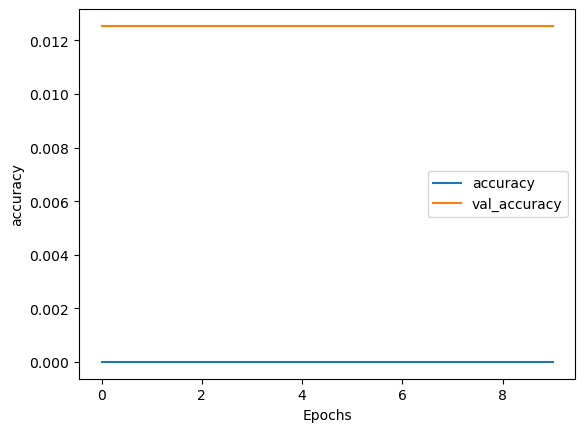

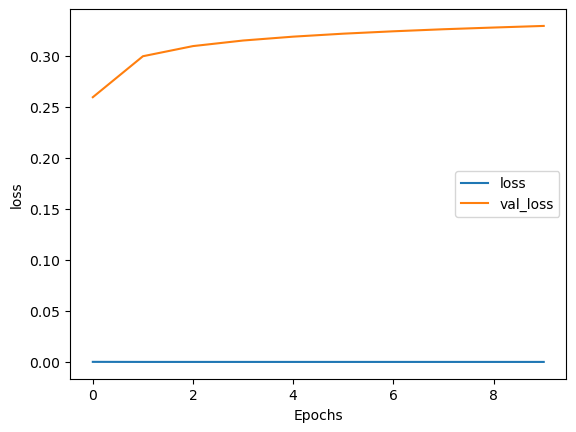

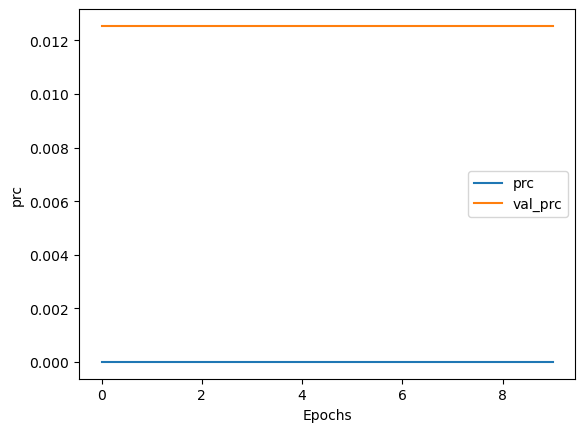

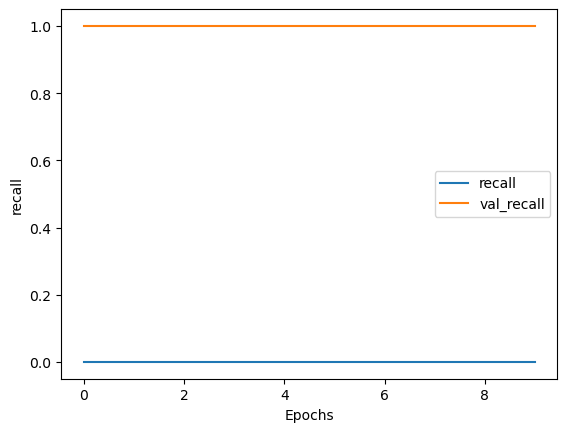

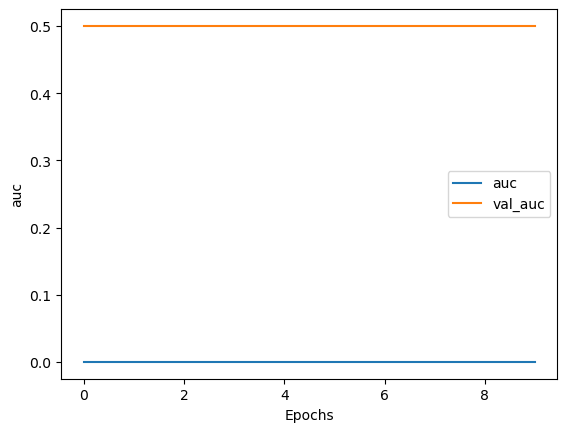

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")
plot_graphs(history, "prc")
plot_graphs(history, "recall")
plot_graphs(history, "auc")

In [ ]:
model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(df.shape[0], embedding_dim, input_length=6),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(6, activation='softmax')
])

In [ ]:
model.summary()

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
num_epochs = 10
history = model.fit(train_padded, train_ds, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_ds), 
                    verbose=2)

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# ds = tf.data.Dataset.from_tensor_slices(([i for i in df['event_sequence']], df['Trace'], df['malicious']))

In [ ]:
# Input data based on - https://www.tensorflow.org/tutorials/structured_data/feature_columns
train, test = train_test_split(df, test_size=0.2)

In [ ]:
train, val = train_test_split(train, test_size=0.2)

In [ ]:
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

In [ ]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('malicious')
  ds = tf.data.Dataset.from_tensor_slices(([i for i in df['event_sequence']], df['malicious']))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [ ]:
# A utility method to create a feature column
# and to transform a batch of data
def make_features(feature_column):  
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch).numpy())

In [ ]:
example_batch = next(iter(train))

In [ ]:
example_batch

In [ ]:
vocab_size = len(set([x[0] for x in df['event_sequence']] ))

In [ ]:
vocab_size

In [ ]:
# Vocabulary size and number of words in a sequence.
vocab_size = vocab_size
sequence_length = 6

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

In [ ]:
batch_size = 5 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [ ]:
text_ds = train_ds.map(lambda x, y: x)

In [ ]:
vectorize_layer.adapt(tf.reshape(text_ds, (len(text_ds),6,1)))

In [ ]:
for sequence_batch, label_batch in train_ds.take(1):
  print('A batch of sequences:', sequence_batch ) # list(feature_batch.keys()))
  print('A batch of targets:', label_batch )

In [ ]:
model = tf.keras.Sequential([
  #feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(1)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)